# <font color='magenta'>Fig2d_Healthy_Mild_and_Severe_from_Kernel_and_BG</font> 

This script is used to analyze the wheat kernel HSI data (VISNIR), written by Kshitiz Dhakal.

Healthy kernel pixels- 2000 data points
Mild kernel pixels- 2000 data points
Severe kernel pixels- 2000 data points

Total: 6000

Labels:
    Healthy kernel pixels- 0
Mild kernel pixels- 1
Severe kernel pixels- 2000 data points   

### Packages and versions:

import sys #Python 3.8.6

import scipy #scipy: 1.6.0

import numpy #numpy: 1.18.5

import matplotlib #matplotlib: 3.3.3

import pandas #pandas: 1.2.1

import sklearn #sklearn: 1.0.2

import xgboost #xgboost: 1.5.1

import seaborn #seaborn: 0.11.1

### Import libraries and check their versions

In [1]:
import sys
print('Python: {}'.format(sys.version))
import scipy
print('scipy: {}'.format(scipy.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import matplotlib
import pandas
print('pandas: {}'.format(pandas.__version__))
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xgboost
print('xgboost: {}'.format(xgboost.__version__))

Python: 3.8.6 | packaged by conda-forge | (default, Dec 26 2020, 04:30:06) [MSC v.1916 64 bit (AMD64)]
scipy: 1.6.0
numpy: 1.23.4
pandas: 1.2.1
sklearn: 1.0.2
xgboost: 1.5.1


### Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import spectral # spectral python (SPy) module for processing hyperspectral images
import spectral.io.envi as envi # load hyperspectral image with ENVI header files
import seaborn as sns
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
from statsmodels.formula.api import ols
from numpy import mean
from numpy import std
from pandas import read_csv
from xgboost import XGBClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB #generative and supervised
from sklearn.neighbors import KNeighborsClassifier #discriminative and supervised
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #discriminative and supervised
from sklearn.neural_network import MLPClassifier #discriminative and supervised
from sklearn.cross_decomposition import PLSRegression #discriminative and supervised
from sklearn.ensemble import RandomForestClassifier#discriminative and supervised
from sklearn import svm
from sklearn.svm import SVC #discriminative and supervised
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold # for five fold cross validation
from sklearn.metrics import confusion_matrix # calcuate confusion matrix
from statannotations.Annotator import Annotator


### Load and pre-process the dataset having random pixel data from three classes of images

#### This dataset was labeled taking Healthy kernel pixels as 0,  Mild kernel pixels as 1 and Severe kernel pixels as 2

In [3]:
d = pd.read_csv('../Input/RF_refined_merged_selected200randomkernelsashealthymildsevere.csv', index_col=0)

In [4]:
#### Extract information from the orginal dataset

In [5]:
array = d.values # save all the values of d as array
labels = array[:,300] # save the labels
features = array[:,0:300] # save the reflectance values of classified pixels as features
features = features*10 # normalize features
wavelengths = d.columns[0:300] # save the column names as wavelengths

#### Rebuild the dataframe to visualize hyperspectral signatures

In [6]:
df = pd.DataFrame(features) #Create a new df having reflecance values only
df_wave = pd.DataFrame(wavelengths) # Add wavelengths in the df
df_wave.columns = ['Wavelength(nm)'] # Add a new column named Wavelength(nm) 
df.columns = df_wave['Wavelength(nm)'] # Add the previous column to the df
df['Label'] = labels # Add labels to the df
df.head() #Display head of df

Wavelength(nm),385.63,387.65,389.67,391.68,393.7,395.72,397.74,399.76,401.79,403.81,...,1009,1011.27,1013.54,1015.81,1018.08,1020.35,1022.63,1024.9,1027.18,Label
0,0.0,0.000,0.813,0.0,0.499,0.0,0.330,1.060,0.638,0.745,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
1,0.0,0.000,0.000,0.0,0.496,0.0,0.328,0.000,0.220,0.000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,3.258,0.0,0.0
2,0.0,0.000,0.000,0.0,0.500,0.0,0.336,0.541,0.223,0.181,...,2.040,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
3,0.0,0.942,0.000,0.0,0.468,0.0,0.333,0.833,0.220,0.546,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
4,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.268,0.635,0.352,...,2.066,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0


#### Create a dataframe df_m with three columns having Label, Wavelength(nm) and Reflectance 

In [7]:
df_m = df.melt(id_vars='Label', value_name='Reflectance') 
df_m.head() # Display df_m

,Label,Wavelength(nm),Reflectance
0,0.0,385.63,0.0
1,0.0,385.63,0.0
2,0.0,385.63,0.0
3,0.0,385.63,0.0
4,0.0,385.63,0.0


### Deploy ML models to train, predict and get accuracy of the prediction

#### Get a list of models to evaluate and define evaluation method

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_predict, train_test_split, StratifiedKFold
def get_models():
    models = []
    models.append(('NB', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('MLPNN', MLPClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVML', SVC(kernel='linear')))
    models.append(('SVMR', SVC(kernel='rbf')))
    models.append(('GBoost', GradientBoostingClassifier()))
    return models

# Evaluate the above models using repeated kfold-cross-validation, which estimates the model accurary/performance based on running k-fold a number of times and calculating the performance across all the repeats. Suited to datasets of smaller scale
def evaluate_models(models,features, labels):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(models, features, labels, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

#### Compare the classification accuracy of all models using all wavelengths

>NB 0.588 (0.018)
>KNN 0.611 (0.017)
>LDA 0.712 (0.016)
>MLPNN 0.735 (0.017)
>RF 0.761 (0.020)
>SVML 0.713 (0.017)
>SVMR 0.732 (0.014)
>GBoost 0.776 (0.018)


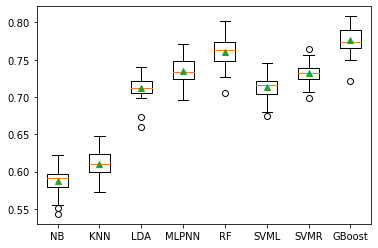

In [9]:
models = get_models()
results = [] ## Store evaluation results
names = []
for name, model in models:
    accuracy = evaluate_models(model, features, labels)
    results.append(accuracy)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(accuracy), std(accuracy)))

plt.boxplot(results, labels=names, showmeans=True)
#plt.savefig('3d_initialseverity2_final3_classification8_MLs_comparision.pdf')
plt.show()

#### Preprocessing evaluation results

In [10]:
# Build a dataframe including cross validation accuracy for each machine learning methods
df_clf_accuracy = pd.DataFrame(results) # Each fold had 30 datapounts(wavelengths) and we had 10 fold so altogether there were 300 datapoints
df_clf_accuracy = df_clf_accuracy.T # Transpose the dataframe
df_clf_accuracy.columns = names #Name the dataframe columns
df_clf_accuracy
#df_clf_accuracy.to_csv(r'../results/b_2class_severity_8_MLs_pixels_comparisionn_all_clf_accuracy.csv', encoding='utf-8', header='true')

,NB,KNN,LDA,MLPNN,RF,SVML,SVMR,GBoost
0,0.593333,0.625000,0.733333,0.771667,0.801667,0.745000,0.743333,0.791667
1,0.621667,0.631667,0.710000,0.735000,0.775000,0.710000,0.738333,0.805000
2,0.600000,0.586667,0.718333,0.753333,0.771667,0.738333,0.748333,0.756667
3,0.596667,0.631667,0.711667,0.716667,0.751667,0.716667,0.726667,0.781667
4,0.570000,0.576667,0.673333,0.708333,0.705000,0.680000,0.698333,0.721667
5,0.588333,0.603333,0.720000,0.741667,0.758333,0.721667,0.720000,0.801667
6,0.568333,0.598333,0.700000,0.728333,0.778333,0.696667,0.733333,0.775000
7,0.566667,0.616667,0.711667,0.721667,0.736667,0.715000,0.733333,0.775000
8,0.595000,0.638333,0.701667,0.760000,0.760000,0.690000,0.728333,0.761667
9,0.578333,0.603333,0.730000,0.715000,0.780000,0.716667,0.746667,0.776667


###  Post hoc pairwise comparison

#### Prepare dataset for anova and pairwise comparison

In [11]:
df1=df_clf_accuracy # 30*8
df2=df1.stack() #  240*1 folds*methods
df3=df2.reset_index() # Folds*methods*number of methods
method=df3['level_1'] #Methods names as independent (predictor) variable
acc_value=df3.iloc[:,2] #Accuracy value from 3rd column as dependent (response) variable
dfanova=pd.DataFrame(method) #Methods names added to dfnnova df
dfanova['Accuracy']=acc_value #Accuracy value  added to dfnnova df
dfanova.columns=['Method','Accuracy'] # Column names to dfannova df

#### Perform Parametric ANOVA with post hoc tests

In [12]:
lm = sfa.ols('Accuracy ~ C(Method)', data=dfanova).fit() # Fit OLS for method(predictor) and acc_value (response variable)
anova = sa.stats.anova_lm(lm) # Run ANOVA for OLS method
anova # The results tell us that there is a significant difference between groups means (p = 3.007666e-130), but does not tell us the exact group pairs which are different in means.

,df,sum_sq,mean_sq,F,PR(>F)
C(Method),7.0,0.972148,0.138878,452.604675,2.095865e-131
Residual,232.0,0.071187,0.000307,NaN,NaN


#### Perform Post hoc tests (To obtain pairwise differences, carry out a posteriori (post hoc) analysis)
##### Student T test applied pairwisely gives p values

In [13]:
#sp.posthoc_ttest(dfanova, val_col='acc_value', group_col='method')
phoc=sp.posthoc_ttest(dfanova, val_col='Accuracy', group_col='Method') # perform p hoc analysis using Accuracy and Method by applying Student T test pairwisely
remove = np.tril(np.ones(phoc.shape), k=0).astype("bool") #Return a copy of an array with elements above the k-th diagonal zeroed
phoc[remove] = np.nan # remove NAs from phoc
molten_df = phoc.melt(ignore_index=False).reset_index().dropna() #reset the indices and melt/stack the phoc results

### Plot the boxplots to see the pairwise differences

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NB vs. KNN: Custom statistical test, P_val:8.414e-06
KNN vs. LDA: Custom statistical test, P_val:6.143e-31
LDA vs. MLPNN: Custom statistical test, P_val:1.361e-06
MLPNN vs. RF: Custom statistical test, P_val:2.374e-06
RF vs. SVML: Custom statistical test, P_val:4.802e-14
SVML vs. SVMR: Custom statistical test, P_val:2.781e-05
SVMR vs. GBoost: Custom statistical test, P_val:1.056e-14
NB vs. LDA: Custom statistical test, P_val:9.386e-35
KNN vs. MLPNN: Custom statistical test, P_val:3.393e-35
LDA vs. RF: Custom statistical test, P_val:9.142e-15
MLPNN vs. SVML: Custom statistical test, P_val:6.098e-06
RF vs. SVMR: Custom statistical test, P_val:3.731e-08
SVML vs. GBoost: Custom statistical test, P_val:6.929e-20
NB vs. MLPNN: Custom statistical test, P_val:2.603e-38
KNN vs. RF: Custom statistical test, P_val:8.42

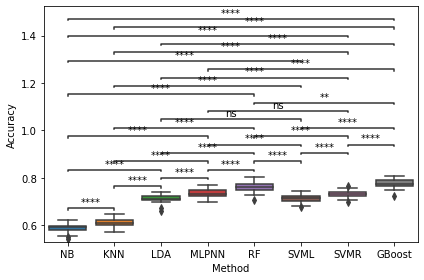

In [14]:
ax=sns.boxplot(data=dfanova, x="Method", y="Accuracy") # Provide the data, and axes for the graph
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()] #store pairs of methods from all methods of molten_df
p_values = [i[1]["value"] for i in molten_df.iterrows()] #storte p_values from molten_df
annotator = Annotator(ax, pairs, data=dfanova, x="Method", y="Accuracy") # provide data to the annotator
annotator.configure(text_format="star", loc="inside") # put star and give the location of the star
annotator.set_pvalues_and_annotate(p_values) #p_values = list or array of p-values for each pair comparison.
#plt.savefig('3b1_2class_severity_pairwise_accuracy_comparison.pdf') # save the plot
plt.tight_layout() # To cover much more space
plt.show()

#### Include pairwise comparison results in the accuracy vs model graph

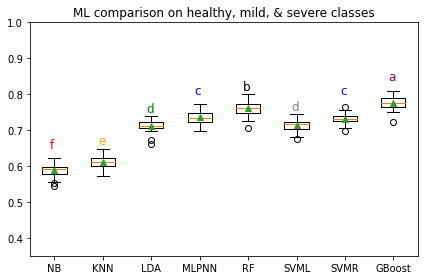

In [15]:
plt.boxplot(results, labels=names, showmeans=True)

plt.text(0.90, 0.65,'f',color='red', fontsize=12)
plt.text(1.9, 0.66,'e',color='orange', fontsize=12)
plt.text(2.9, 0.75,'d',color='green', fontsize=12)
plt.text(3.9, 0.8,'c',color='blue', fontsize=12)
plt.text(4.9, 0.81,'b',color='black', fontsize=12)
plt.text(5.9, 0.755,'d',color='grey', fontsize=12)
plt.text(6.9, 0.80,'c',color='blue', fontsize=12)
plt.text(7.9, 0.84,'a',color='purple', fontsize=12)

plt.ylim([0.35, 1.0])
plt.title('ML comparison on healthy, mild, & severe classes')
plt.tight_layout()
plt.savefig('../Output/Fig2d_3class_severity_8_MLs_pixels_pairwise_accuracy_comparison.pdf')
plt.show()